In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.preprocessing import StandardScaler



In [237]:
datos_originales_conjunto_1 = pd.read_csv('Y_modificado.csv')
datos_originales_conjunto_1

,indice,Date,Price
0,0,2006-11-07,555.00
1,1,2006-12-07,555.00
2,2,2006-07-13,555.00
3,3,2006-07-14,555.00
4,4,2006-07-17,555.00
...,...,...,...
4480,4480,2023-06-09,552.50
4481,4481,2023-07-09,550.00
4482,4482,2023-08-09,545.00
4483,4483,2023-11-09,546.00


In [238]:
df = datos_originales_conjunto_1
# Convertir la columna 'fecha' a tipo datetime
df['Date'] = pd.to_datetime(df['Date'])

# Establecer la columna 'fecha' como índice
df.set_index('Date', inplace=True)


In [239]:
# las fechas están en desorden. Las ordenamos desde la "menor" fecha a la "mayor" (recordadndo que es DateTime)
df = df.sort_index()
df

,indice,Price
Date,,
2006-01-08,15,525.00
2006-01-09,38,485.00
2006-01-11,81,485.00
2006-01-12,103,470.00
2006-02-08,16,525.00
...,...,...
2023-12-04,4375,610.00
2023-12-05,4397,550.00
2023-12-06,4418,540.00


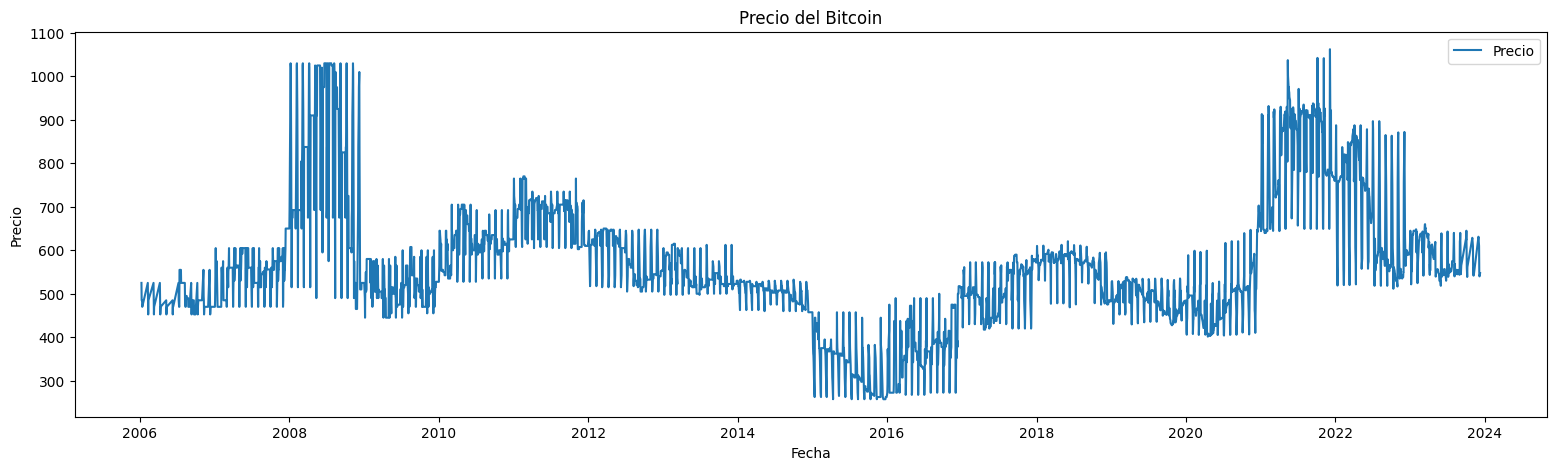

In [240]:
plt.figure(figsize=(19, 5))
plt.plot(df['Price'], label='Precio')
plt.title('Precio del Bitcoin')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()

Error cuadrático medio (MSE): 2964.4288901661102


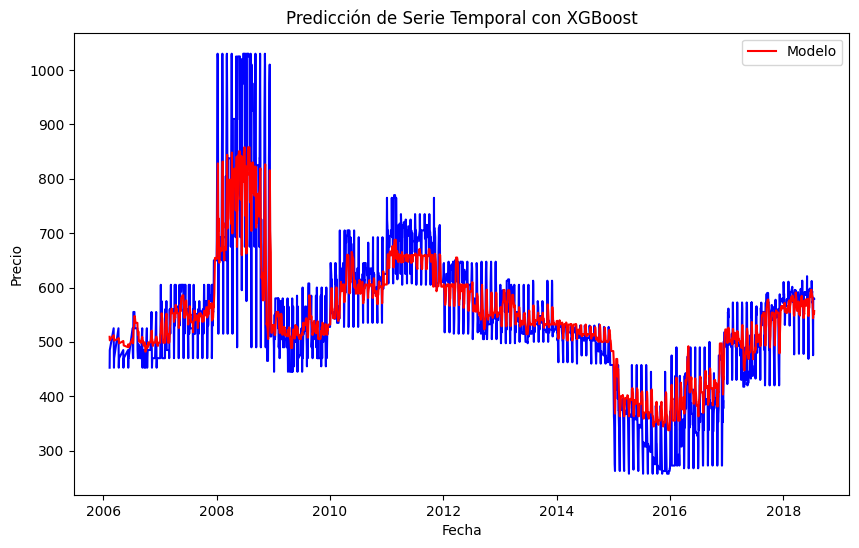

In [241]:
# Crear características de serie temporal (lag features)
def create_lag_features(df, lags=5):
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['Price'].shift(lag)
    df = df.dropna()  # Eliminar filas con valores nulos
    return df

# Crear características de lag
df = create_lag_features(df, lags=5)

# Dividir los datos en conjunto de entrenamiento y prueba
train_size = int(len(df) * 0.7)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Separar las características (X) y el target (y)
X_train = train.drop(columns=['Price'])
y_train = train['Price']
X_test = test.drop(columns=['Price'])
y_test = test['Price']

# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1500, max_depth=4, learning_rate=0.001, colsample_bytree=0.3, reg_alpha=0.1, reg_lambda=0.1)

# Entrenar el modelo
model.fit(X_train_scaled, y_train)

# Hacer predicciones
predictions = model.predict(X_train_scaled)

# Convertir las predicciones a un DataFrame
futuros = pd.DataFrame(predictions, index=train.index, columns=['Prediction'])


# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_train, predictions)
print(f"Error cuadrático medio (MSE): {mse}")

# Graficar las predicciones y los valores reales
plt.figure(figsize=(10, 6))
plt.plot(train.index, y_train, label='', color='blue')
plt.plot(train.index, predictions, label='Modelo', color='red')
plt.title('Predicción de Serie Temporal con XGBoost')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()



In [242]:
df

,indice,Price,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,
2006-02-10,59,452.50,525.00,470.00,485.00,485.00,525.00
2006-02-11,82,485.00,452.50,525.00,470.00,485.00,485.00
2006-03-08,17,525.00,485.00,452.50,525.00,470.00,485.00
2006-03-10,60,452.50,525.00,485.00,452.50,525.00,470.00
2006-03-11,83,470.00,452.50,525.00,485.00,452.50,525.00
...,...,...,...,...,...,...,...
2023-12-04,4375,610.00,631.18,546.00,560.00,541.67,550.00
2023-12-05,4397,550.00,610.00,631.18,546.00,560.00,541.67
2023-12-06,4418,540.00,550.00,610.00,631.18,546.00,560.00


In [243]:
# Hacer que futuros cuente el index como una columna
futuros.reset_index(level=0, inplace=True)
futuros = futuros.rename(columns={'Prediction': 'Price'})
futuros

,Date,Price
0,2006-02-10,509.343079
1,2006-02-11,502.877014
2,2006-03-08,512.162781
3,2006-03-10,507.015930
4,2006-03-11,502.480743
...,...,...
3131,2018-07-13,549.906189
3132,2018-07-16,553.060669
3133,2018-07-17,553.576721
3134,2018-07-18,551.033997


In [244]:

import skforecast
import sklearn
from xgboost import XGBRegressor
from sklearn.feature_selection import RFECV
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.feature_selection import select_features
from skforecast.preprocessing import RollingFeatures
import shap


In [245]:
# Create forecaster
# ==============================================================================
end_validation = '2023-12-09'

window_features = RollingFeatures(stats=["coef_variation"], window_sizes=4200)
forecaster = ForecasterRecursive(
                regressor       = XGBRegressor(random_state=15926, enable_categorical=True),
                lags            = 3000,
                window_features = window_features
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=df.loc[:end_validation, 'Price'])
forecaster

c:\Users\quint.LAPTOP-LGVR2QRN\anaconda3\lib\site-packages\skforecast\utils\utils.py:1157: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
c:\Users\quint.LAPTOP-LGVR2QRN\anaconda3\lib\site-packages\skforecast\utils\utils.py:1157: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


=================== 
ForecasterRecursive 
=================== 
Regressor: XGBRegressor 
Lags: [   1    2    3 ... 2998 2999 3000] 
Window features: ['roll_coef_variation_4200'] 
Window size: 4200 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [0, 4479] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: 
    {'objective': 'reg:squarederror', 'base_score': None, 'booster': None,
    'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None,
    'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None,
    'enable_categorical': True, 'eval_metric': None, 'feature_types': None,
    'gamma': None, 'grow_policy': None, 'importance_type': None,
    'interaction_constraints': None, 'learning_rate': None, 'max_bin': None,
    'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step':
    None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None,
    'missing': nan, 'monotone_constraints': None, 'multi_strategy': None,
    'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None,
    'random_state': 15926, 'reg_alpha': None, 'reg_lambda': None,
    'sampling_method': None, 'scale_pos_weight': None, 'subsample': None,
    'tree_method': None, 'validate_parameters': None, 'verbosity': None} 
fit_kwargs: {} 
Creation date: 2024-12-04 16:44:03 
Last fit date: 2024-12-04 16:44:21 
Skforecast version: 0.14.0 
Python version: 3.10.11 
Forecaster id: None

In [246]:
final = forecaster.predict(steps=365)
final


c:\Users\quint.LAPTOP-LGVR2QRN\anaconda3\lib\site-packages\skforecast\utils\utils.py:1219: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


4200    549.496643
4201    586.060425
4202    600.209167
4203    599.901489
4204    556.863525
           ...    
4560    607.886047
4561    586.421570
4562    606.458435
4563    578.338806
4564    614.077698
Name: pred, Length: 365, dtype: float64

### predicción 2 años

In [247]:
'''
graficar SOLAMENTE las predicciones futuras
plt.figure(figsize=(10, 6))
plt.plot(future.index, future['Prediction'], label='Predicción Futura', color='red')
plt.title('Futuro de la materia prima X')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()
'''
final_2_anios = forecaster.predict(steps=730)
final_2_anios

c:\Users\quint.LAPTOP-LGVR2QRN\anaconda3\lib\site-packages\skforecast\utils\utils.py:1219: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


4200    549.496643
4201    586.060425
4202    600.209167
4203    599.901489
4204    556.863525
           ...    
4925    607.830200
4926    594.162903
4927    588.218445
4928    610.368958
4929    589.301819
Name: pred, Length: 730, dtype: float64

In [248]:
final_3_anios = forecaster.predict(steps=1095)
final_3_anios

c:\Users\quint.LAPTOP-LGVR2QRN\anaconda3\lib\site-packages\skforecast\utils\utils.py:1219: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


4200    549.496643
4201    586.060425
4202    600.209167
4203    599.901489
4204    556.863525
           ...    
5290    584.330017
5291    582.557800
5292    583.763062
5293    571.796143
5294    568.934692
Name: pred, Length: 1095, dtype: float64

---

---